In [15]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,KFold
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

In [3]:
data = fetch_openml("credit-g")

In [4]:
X = data["data"]
y = data["target"]
features = data["feature_names"]

In [5]:
categorical_columns = list(data["categories"].keys())
continuous_columns = list(set(features) - set(categorical_columns))
category_values = list(data["categories"].values())

In [6]:
categorical_columns_index = [i for i,v in enumerate(features) if(v in categorical_columns)]
continuous_columns_index = [i for i,v in enumerate(features) if(v in continuous_columns)]

In [7]:
print("- Following is the list of continuous features:")
print(continuous_columns)
print()
print("- Following is the list of categorical features:")
print(categorical_columns)

- Following is the list of continuous features:
['residence_since', 'installment_commitment', 'age', 'duration', 'credit_amount', 'existing_credits', 'num_dependents']

- Following is the list of categorical features:
['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']


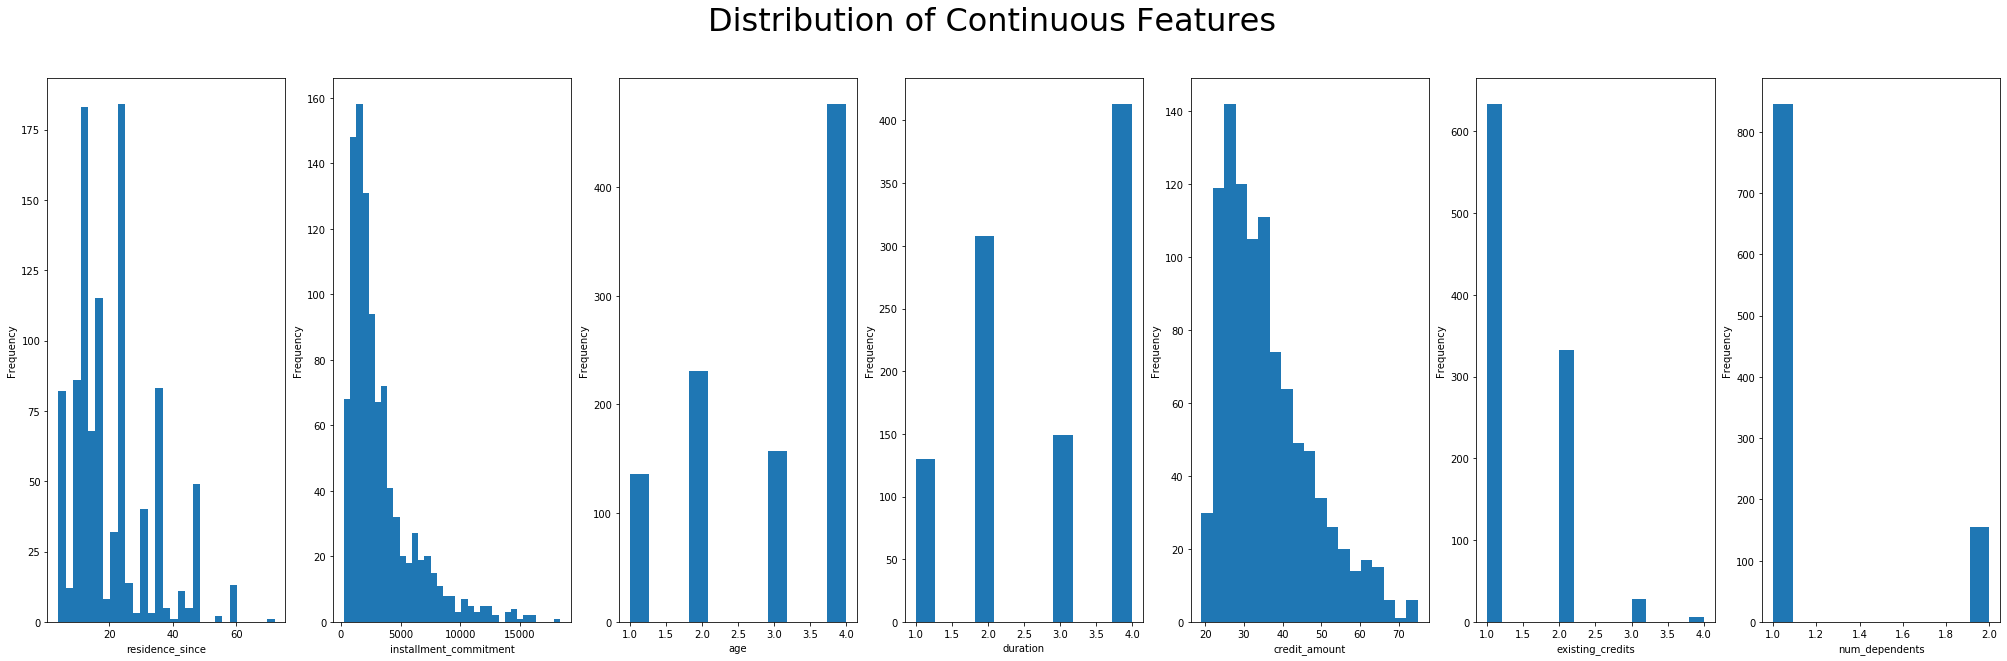

In [8]:
fig, axes = plt.subplots(1, len(continuous_columns_index) , figsize=(35, 10))

for i in range(len(continuous_columns_index)):
    axes[i].hist(X[:,continuous_columns_index[i]],bins = "auto")
    axes[i].set_xlabel(continuous_columns[i])
    axes[i].set_ylabel("Frequency")

fig.suptitle("Distribution of Continuous Features", fontsize=32)
plt.show()

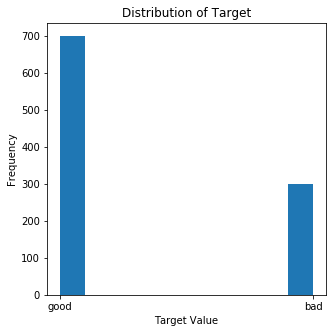

In [9]:
fig, axes = plt.subplots(figsize=(5, 5))
axes.hist(y)
axes.set_xlabel("Target Value")
axes.set_ylabel("Frequency")
axes.set_title("Distribution of Target")

plt.show()

In [10]:
X_df = pd.DataFrame(X, columns = features)
y_df = pd.DataFrame(y, columns = ["target"])

In [11]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_df, y_df, test_size=0.20, random_state=42)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.20, random_state=42)

In [16]:
ohe = OneHotEncoder(categorical_features=categorical_columns_index, handle_unknown="ignore")
ohe = ohe.fit(X_train)
X_train_preprocessed = ohe.transform(X_train)
X_val_preprocessed = ohe.transform(X_val)

In [17]:
log_reg = LogisticRegression(random_state = 42)

In [18]:
log_reg.fit(X_train_preprocessed,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
score = log_reg.score(X_val_preprocessed,y_val)
print("The validation score for Logistic Regression is: " + str(score))

The validation score for Logistic Regression is: 0.7375


In [20]:
model_names = ["LogisticRegression", "LinearSVC", "KNeighboursClassifier"]
model_list = [ LogisticRegression(), LinearSVC(), KNeighborsClassifier()]

In [21]:
preprocess = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), categorical_columns_index))

scores = []
for i in range(len(model_list)):
    score = cross_val_score(make_pipeline(preprocess, model_list[i]), X_train_val, y_train_val, cv=5)
    scores.append(np.mean(score))
    
for i in range(len(model_names)):
    print("The validation score for " + model_names[i] +" is " + str(scores[i]))

The validation score for LogisticRegression is 0.7374332981757099
The validation score for LinearSVC is 0.7336755342005546
The validation score for KNeighboursClassifier is 0.6974330051955155


In [22]:
preprocess = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), categorical_columns_index),(StandardScaler(), continuous_columns_index))

scores = []
for i in range(len(model_list)):
    score = cross_val_score(make_pipeline(preprocess, model_list[i]), X_train_val, y_train_val, cv=5)
    scores.append(np.mean(score))
    
for i in range(len(model_names)):
    print("The validation score for " + model_names[i] +" is " + str(scores[i]))

The validation score for LogisticRegression is 0.7436911598109301
The validation score for LinearSVC is 0.7411990214461502
The validation score for KNeighboursClassifier is 0.7361833958357749


We can see that the scaling helps a lot in the case of KNearestNeighbours classifier which is quite intutive from the fact that it relies upon the distances and use them intensively for the prediction of the class. 

The results for Linear SVM and Logistic Regression also are improved but not as much as that of KNearestNeighbours Classifier.

In [23]:
preprocess = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), categorical_columns_index),(StandardScaler(), continuous_columns_index))

pipe = Pipeline([('preprocess', preprocess),
                 ('classfier', LogisticRegression())])

param_grid = [{'classfier': [LogisticRegression(random_state=42)],
               'classfier__C': np.logspace(-3, 2, 10)},
              {'classfier': [LinearSVC(random_state=42)],
               'classfier__C': np.logspace(-3, 2, 10)},
              {'classfier': [KNeighborsClassifier()],
               'classfier__n_neighbors': range(1,15,2)}
             ]
grid = GridSearchCV(pipe, param_grid)
grid.fit(X_train_val, y_train_val)
best_score = grid.score(X_test, y_test)

print("The best score:" + str(best_score))
print("The best method along with its parameter values is: " + str(grid.best_params_))

The best score:0.79
The best method along with its parameter values is: {'classfier': LogisticRegression(C=0.1668100537200059, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), 'classfier__C': 0.1668100537200059}


In [24]:
plots = pd.DataFrame(grid.cv_results_)
plots["LR"]= [isinstance(plots["param_classfier"][i],LogisticRegression) for i in range(plots.shape[0])]
plots["SVM"] = [isinstance(plots["param_classfier"][i],LinearSVC) for i in range(plots.shape[0])]
plots["KNN"] = [isinstance(plots["param_classfier"][i],KNeighborsClassifier) for i in range(plots.shape[0])]

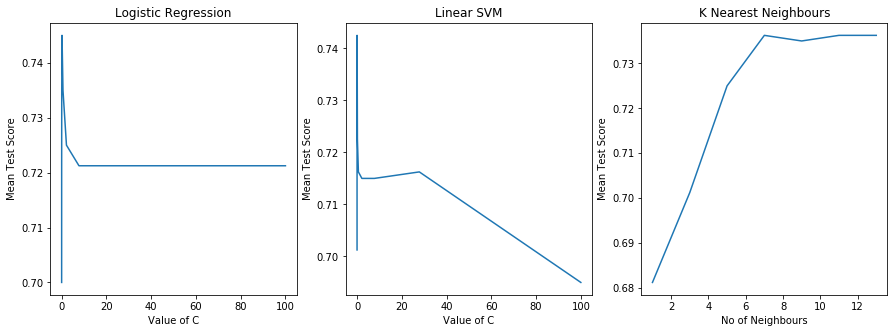

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(plots[plots["LR"]]["param_classfier__C"],plots[plots["LR"]]["mean_test_score"])
axes[1].plot(plots[plots["SVM"]]["param_classfier__C"],plots[plots["SVM"]]["mean_test_score"])
axes[2].plot(plots[plots["KNN"]]["param_classfier__n_neighbors"],plots[plots["KNN"]]["mean_test_score"])
axes[0].set_xlabel("Value of C")
axes[0].set_ylabel("Mean Test Score")
axes[0].set_title("Logistic Regression")

axes[1].set_xlabel("Value of C")
axes[1].set_ylabel("Mean Test Score")
axes[1].set_title("Linear SVM")

axes[2].set_xlabel("No of Neighbours")
axes[2].set_ylabel("Mean Test Score")
axes[2].set_title("K Nearest Neighbours")

plt.show()

The results as can be seen has improved from all of the three case having scores (0.74, 0.74, 0.73) respectively. While after the gridsearch it can be seen that the best model is found to have a score of 0.79.

In [26]:
preprocess = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), categorical_columns_index),(StandardScaler(), continuous_columns_index))

pipe = Pipeline([('preprocess', preprocess),
                 ('classfier', LogisticRegression())])

param_grid = [{'classfier': [LogisticRegression(random_state=42)],
               'classfier__C': np.logspace(-3, 2, 10)},
              {'classfier': [LinearSVC(random_state=42)],
               'classfier__C': np.logspace(-3, 2, 10)},
              {'classfier': [KNeighborsClassifier()],
               'classfier__n_neighbors': range(1,15,2)}
             ]
grid = GridSearchCV(pipe, param_grid,cv = KFold(shuffle=True , random_state=100))
grid.fit(X_train_val, y_train_val)
best_score = grid.score(X_test, y_test)

print("The best score (on the test):" + str(best_score))
print("The best method along with its parameter values is: " + str(grid.best_params_))

The best score (on the test):0.77
The best method along with its parameter values is: {'classfier': LogisticRegression(C=0.046415888336127795, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), 'classfier__C': 0.046415888336127795}


In [27]:
preprocess = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), categorical_columns_index),(StandardScaler(), continuous_columns_index))

pipe = Pipeline([('preprocess', preprocess),
                 ('classfier', LogisticRegression())])

param_grid = [{'classfier': [LogisticRegression(random_state=42)],
               'classfier__C': np.logspace(-3, 2, 10)},
              {'classfier': [LinearSVC(random_state=42)],
               'classfier__C': np.logspace(-3, 2, 10)},
              {'classfier': [KNeighborsClassifier()],
               'classfier__n_neighbors': range(1,15,2)}
             ]
grid = GridSearchCV(pipe, param_grid,cv = KFold(shuffle=True , random_state=42))
grid.fit(X_train_val, y_train_val)
best_score = grid.score(X_test, y_test)

print("The best score (on the test):" + str(best_score))
print("The best method along with its parameter values is: " + str(grid.best_params_))

The best score (on the test):0.79
The best method along with its parameter values is: {'classfier': LogisticRegression(C=0.1668100537200059, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), 'classfier__C': 0.1668100537200059}


In [28]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_df, y_df, test_size=0.20, random_state=83)

preprocess = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), categorical_columns_index),(StandardScaler(), continuous_columns_index))

pipe = Pipeline([('preprocess', preprocess),
                 ('classfier', LogisticRegression())])

param_grid = [{'classfier': [LogisticRegression(random_state=42)],
               'classfier__C': np.logspace(-3, 2, 10)},
              {'classfier': [LinearSVC(random_state=42)],
               'classfier__C': np.logspace(-3, 2, 10)},
              {'classfier': [KNeighborsClassifier()],
               'classfier__n_neighbors': range(1,15,2)}
             ]
grid = GridSearchCV(pipe, param_grid,cv = KFold(shuffle=True , random_state=42))
grid.fit(X_train_val, y_train_val)
best_score = grid.score(X_test, y_test)

print("The best score (on the test):" + str(best_score))
print("The best method along with its parameter values is: " + str(grid.best_params_))


The best score (on the test):0.72
The best method along with its parameter values is: {'classfier': LogisticRegression(C=2.1544346900318843, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), 'classfier__C': 2.1544346900318843}


- The above 3 blocks of code show that the results change with change in value of random seed. These changes are evident from change in random seed's value at both the positions (i.e.) while performing the train_test split as well as one used in the KFold method to indicate random shuffling.

In [29]:
preprocess = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), categorical_columns_index),(StandardScaler(), continuous_columns_index))

pipe1 = Pipeline([('preprocess', preprocess),
                 ('classifier', LogisticRegression(random_state=42))])

param_grid = [{'classifier__C': np.logspace(-3, 2, 10)}]
grid = GridSearchCV(pipe1, param_grid)
grid.fit(X_train_val, y_train_val)
best_score = grid.score(X_test, y_test)

print("The best parameter values for Logistic Regression: " + str(grid.best_params_))

The best parameter values for Logistic Regression: {'classifier__C': 0.1668100537200059}


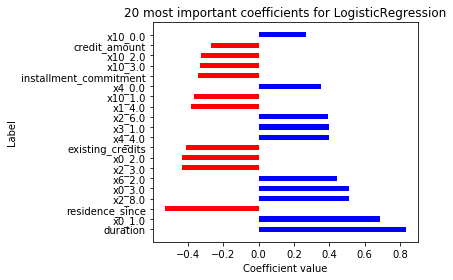

In [30]:
pipe = Pipeline([('scaler', preprocess),('classifier', LogisticRegression(C=grid.best_params_["classifier__C"]))])
pipe.fit(X_train_val,y_train_val)

coefficients=pipe.get_params()['classifier'].coef_
cat_names= list(preprocess.named_transformers_['onehotencoder'].get_feature_names())
features = continuous_columns.copy()
features.extend(cat_names)


coefficient_list = list(coefficients[0])

# combined_list = [(i,j) for i,j in zip(coefficient_list,features)]
# sorted_combination =sorted(combined_list, key = lambda x: abs(x[0]),reverse=True)
# top_20 = sorted_combination[:20]

fig, axes = plt.subplots()
for coef in sorted(coefficient_list,key = lambda x: abs(x),reverse=True)[:20]:
    plt.barh(features[coefficient_list.index(coef)], coef, height=.5, color=plt.cm.bwr_r(np.sign(coef)))
    
plt.xlabel("Coefficient value")
plt.ylabel("Label")
plt.title("20 most important coefficients for LogisticRegression")
plt.tight_layout()

In [31]:
preprocess = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), categorical_columns_index),(StandardScaler(), continuous_columns_index))

pipe1 = Pipeline([('preprocess', preprocess),
                 ('classifier', LinearSVC(random_state=42))])

param_grid = [{'classifier__C': np.logspace(-3, 2, 10)}]
grid = GridSearchCV(pipe1, param_grid)

grid.fit(X_train_val, y_train_val)
best_score = grid.score(X_test, y_test)

print("The best parameter values for Linear SVM: " + str(grid.best_params_))

The best parameter values for Linear SVM: {'classifier__C': 0.046415888336127795}


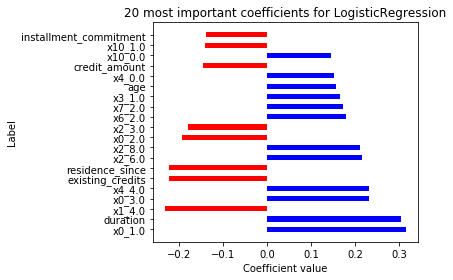

In [32]:
pipe = Pipeline([('scaler', preprocess),('classifier', LinearSVC(C=grid.best_params_["classifier__C"]))])
pipe.fit(X_train_val,y_train_val)

coefficients=pipe.get_params()['classifier'].coef_
cat_names= list(preprocess.named_transformers_['onehotencoder'].get_feature_names())
features = continuous_columns.copy()
features.extend(cat_names)

coefficient_list = list(coefficients[0])

# combined_list = [(i,j) for i,j in zip(coefficient_list,features)]
# sorted_combination =sorted(combined_list, key = lambda x: abs(x[0]),reverse=True)
# top_20 = sorted_combination[:20]

fig, axes = plt.subplots()
for coef in sorted(coefficient_list,key = lambda x: abs(x),reverse=True)[:20]:
    plt.barh(features[coefficient_list.index(coef)], coef, height=.5, color=plt.cm.bwr_r(np.sign(coef)))
    
plt.xlabel("Coefficient value")
plt.ylabel("Label")
plt.title("20 most important coefficients for LogisticRegression")
plt.tight_layout()